In [1]:
# 0.1 Imports
import os, re, json, math, warnings
from pathlib import Path
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve, precision_score, recall_score, f1_score
)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# If xgboost is available, we’ll use it; otherwise we’ll skip gracefully.
try:
    from xgboost import XGBClassifier
    XGB_OK = True
except Exception:
    XGB_OK = False

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

DATA_PATH = Path("data")
RAW_DATA_FILE = DATA_PATH/"census-bureau.data"
RAW_COLS_FILE = DATA_PATH/"census-bureau.columns"


In [2]:
# 1.1 Load columns (each line is a column name)
cols = pd.read_csv(RAW_COLS_FILE, header=None, names=["col"])["col"].str.strip().tolist()

# 1.2 Load data (comma separated)
df = pd.read_csv(RAW_DATA_FILE, header=None, names=cols)
print(df.shape)
df.head(3)


(199523, 42)


,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,label
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.


In [3]:
# 1.3 Apply your target mapping exactly (with whitespace robustness)
import re

# Your mapping
target_map = {'- 50000.': 0, ' - 50000.': 0, '50000+.': 1, ' 50000+.': 1}

def _norm_key(s):
    s = "" if pd.isna(s) else str(s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

# Normalize keys in the provided map so minor whitespace differences still match
_target_map_norm = {_norm_key(k): v for k, v in target_map.items()}

# Build label_bin using the normalized keys
df["label_bin"] = df["label"].map(lambda x: _target_map_norm.get(_norm_key(x), np.nan)).astype("float")

# Keep only rows that mapped successfully (0/1) and (if present) positive weights
weight_col_candidates = [c for c in df.columns if "weight" in c.lower() or "wt" in c.lower()]
weight_col = weight_col_candidates[0] if weight_col_candidates else None
if weight_col is None:
    df["weight"] = 1.0
    weight_col = "weight"

df = df[df["label_bin"].isin([0.0, 1.0])].copy()
df = df[df[weight_col].fillna(0) > 0].copy()

# Light categorical trimming (optional but useful later)
def strip_cat(val):
    if pd.isna(val): return val
    return re.sub(r"\s+", " ", str(val)).strip()

for c in df.select_dtypes(include="object").columns:
    if c not in ["label"]:   # leave original label untouched
        df[c] = df[c].map(strip_cat)

df["label_bin"].value_counts(dropna=False), df[weight_col].describe()


(label_bin
 0.0    187141
 1.0     12382
 Name: count, dtype: int64,
 count    199523.000000
 mean       1740.380269
 std         993.768156
 min          37.870000
 25%        1061.615000
 50%        1618.310000
 75%        2188.610000
 max       18656.300000
 Name: weight, dtype: float64)

In [4]:
# 2) Train/test split (stratified), feature typing — FIXED to prevent leakage
import re

label_col = "label_bin"  # our numeric target

# Start from all features, then drop target and target-like columns
X = df.drop(columns=[label_col]).copy()

# Drop explicit label/text targets and anything suspiciously target-y
suspect_regex = re.compile(r"(?i)\b(label|income|earn|target|>50|<=50|50k)\b")
leak_cols = [c for c in X.columns if suspect_regex.search(c)]
if leak_cols:
    print("Dropping suspect columns (possible leakage):", leak_cols)
    X = X.drop(columns=leak_cols)

# Also drop the weight if present
if weight_col in X.columns:
    X = X.drop(columns=[weight_col])

y = df[label_col].astype(int).values
w = df[weight_col].astype(float).values

# Type inference
cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if c not in cat_cols]

# Split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

len(y_train), len(y_test), y.mean().round(4)


Dropping suspect columns (possible leakage): ['label']


(159618, 39905, 0.0621)

In [5]:
# 3.1 Mark rare categories in training set
RARE_THRESH = 0.005  # 0.5% by weighted frequency

def rare_mapper(series, weights, thresh=RARE_THRESH):
    s = series.fillna("MISSING").astype(str)
    # weighted frequencies
    wf = pd.Series(weights, index=s.index).groupby(s).sum()
    wf = wf / wf.sum()
    rare_vals = set(wf[wf < thresh].index.tolist())
    return s.where(~s.isin(rare_vals), other="__RARE__")

X_train_cat = X_train[cat_cols].copy()
X_test_cat  = X_test[cat_cols].copy()

for c in cat_cols:
    X_train_cat[c] = rare_mapper(X_train_cat[c], w_train)
    # map test: unseen -> __RARE__
    tr_vals = set(X_train_cat[c].dropna().unique())
    X_test_cat[c] = X_test_cat[c].fillna("MISSING").astype(str)
    X_test_cat[c] = X_test_cat[c].where(X_test_cat[c].isin(tr_vals), other="__RARE__")

X_train = pd.concat([X_train[num_cols], X_train_cat], axis=1)
X_test  = pd.concat([X_test[num_cols],  X_test_cat],  axis=1)

# 3.2 Missingness indicators for numerics
miss_flag_cols = [f"{c}__was_missing" for c in num_cols]
X_train[miss_flag_cols] = X_train[num_cols].isna().astype(int)
X_test[miss_flag_cols]  = X_test[num_cols].isna().astype(int)


In [6]:
# 4.1 Numeric: impute median + PowerTransformer(Yeo-Johnson)
num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("yeojohnson", PowerTransformer(method="yeo-johnson", standardize=True)),
])

# 4.2 Categorical: impute "MISSING" (should already be handled) + OHE (drop in case of multicollinearity)
cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse=True))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols)
    ],
    remainder="drop"
)


In [7]:
def evaluate_prob(y_true, y_prob, weights, verbose=True):
    roc = roc_auc_score(y_true, y_prob, sample_weight=weights)
    pr  = average_precision_score(y_true, y_prob, sample_weight=weights)
    if verbose:
        print(f"ROC-AUC: {roc:.4f} | PR-AUC: {pr:.4f}")
    return {"roc_auc": roc, "pr_auc": pr}

def threshold_report(y_true, y_prob, weights, target="f1", min_recall=None, min_precision=None):
    """
    Sweep thresholds and return the best threshold by chosen objective.
    Supports constraints like min_recall or min_precision.
    """
    thresholds = np.linspace(0.01, 0.99, 99)
    best = {"thr": 0.5, "precision": 0, "recall": 0, "f1": 0}
    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        prec = precision_score(y_true, y_pred, sample_weight=weights, zero_division=0)
        rec  = recall_score(y_true, y_pred, sample_weight=weights, zero_division=0)
        f1   = f1_score(y_true, y_pred, sample_weight=weights, zero_division=0)
        if min_recall is not None and rec < min_recall: 
            continue
        if min_precision is not None and prec < min_precision:
            continue
        score = {"precision": prec, "recall": rec, "f1": f1}[target]
        if score > best[target]:
            best = {"thr": float(t), "precision": float(prec), "recall": float(rec), "f1": float(f1)}
    return best


In [8]:
models = []

# 6.1 Logistic Regression (liblinear for stability)
logit = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf",  LogisticRegression(
        solver="liblinear",
        class_weight=None,  # we will use sample_weight instead
        random_state=RANDOM_STATE,
        max_iter=200
    ))
])
models.append(("logit", logit))

# 6.2 Random Forest (weighted via sample_weight)
rf = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf",  RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        min_samples_split=2,
        n_jobs=-1,
        random_state=RANDOM_STATE
    ))
])
models.append(("rf", rf))

# 6.3 XGBoost (if available)
if XGB_OK:
    xgb = Pipeline(steps=[
        ("prep", preprocessor),
        ("clf", XGBClassifier(
            n_estimators=500,
            max_depth=6,
            learning_rate=0.08,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            random_state=RANDOM_STATE,
            tree_method="hist",
            eval_metric="logloss",
            n_jobs=-1
        ))
    ])
    models.append(("xgb", xgb))

# 6.4 Fit + evaluate (weighted)
results = []
for name, pipe in models:
    pipe.fit(X_train, y_train, **({"clf__sample_weight": w_train} if name!="xgb" else {"clf__sample_weight": w_train}))
    # predict_proba
    y_prob = pipe.predict_proba(X_test)[:,1]
    print(f"\n[{name}]")
    metrics = evaluate_prob(y_test, y_prob, w_test, verbose=True)
    best = threshold_report(y_test, y_prob, w_test, target="f1")
    print("Best threshold by F1:", best)
    results.append((name, pipe, metrics, best))

# Select top-2 by PR-AUC
results_sorted = sorted(results, key=lambda r: r[2]["pr_auc"], reverse=True)
[(r[0], r[2]) for r in results_sorted]



[logit]
ROC-AUC: 0.9429 | PR-AUC: 0.6004
Best threshold by F1: {'thr': 0.27, 'precision': 0.5322847628752929, 'recall': 0.6071749110026243, 'f1': 0.567268787015425}

[rf]
ROC-AUC: 0.9394 | PR-AUC: 0.6014
Best threshold by F1: {'thr': 0.27, 'precision': 0.5161750307513786, 'recall': 0.6447592024353495, 'f1': 0.5733461752277761}

[xgb]
ROC-AUC: 0.9473 | PR-AUC: 0.6136
Best threshold by F1: {'thr': 0.3, 'precision': 0.568111458837983, 'recall': 0.6242685437226462, 'f1': 0.5948675964362335}


[('xgb', {'roc_auc': 0.9472552133755503, 'pr_auc': 0.6135878443803715}),
 ('rf', {'roc_auc': 0.9394106626427821, 'pr_auc': 0.6013724432761169}),
 ('logit', {'roc_auc': 0.9428806217484988, 'pr_auc': 0.6003951917954822})]

In [10]:
# 6.5 — Calibration WITHOUT "prefit": use sigmoid + StratifiedKFold inside a single pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.pipeline import Pipeline

calibrated = []

# Cal folds (stratified, shuffled)
cal_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

for name, pipe, metrics, best in results_sorted[:2]:
    print(f"\n== Calibrating {name} with sigmoid + 3-fold StratifiedKFold ==")

    # grab fitted pipe's pieces to replicate its config
    base_prep = pipe.named_steps["prep"]
    base_est  = pipe.named_steps["clf"]

    # fresh, unfitted copies
    prep_clone = clone(base_prep)
    est_clone  = clone(base_est)

    # build a single pipeline: prep -> Calibrated(est_clone)
    cal = CalibratedClassifierCV(
        base_estimator=est_clone,
        method="sigmoid",
        cv=cal_cv,
    )
    cal_pipe = Pipeline([("prep", prep_clone), ("cal", cal)])

    # fit once on the full TRAIN (calibration runs internally with CV)
    cal_pipe.fit(X_train, y_train, cal__sample_weight=w_train)

    # evaluate on TEST
    y_prob = cal_pipe.predict_proba(X_test)[:, 1]
    print("prob range:", float(y_prob.min()), "→", float(y_prob.max()))
    metrics2 = evaluate_prob(y_test, y_prob, w_test, verbose=True)
    best2 = threshold_report(y_test, y_prob, w_test, target="f1")
    print("Best threshold by F1:", best2)

    calibrated.append((f"cal_{name}", cal_pipe, metrics2, best2))

calibrated_sorted = sorted(calibrated, key=lambda r: r[2]["pr_auc"], reverse=True)
[(r[0], r[2]) for r in calibrated_sorted]



== Calibrating xgb with sigmoid + 3-fold StratifiedKFold ==
prob range: 0.021348123128215473 → 0.9636767903963724
ROC-AUC: 0.9480 | PR-AUC: 0.6425
Best threshold by F1: {'thr': 0.21000000000000002, 'precision': 0.5905656470355486, 'recall': 0.601246267029648, 'f1': 0.5958580989594778}

== Calibrating rf with sigmoid + 3-fold StratifiedKFold ==
prob range: 0.0171193949586266 → 0.9893047081889214
ROC-AUC: 0.9424 | PR-AUC: 0.6161
Best threshold by F1: {'thr': 0.21000000000000002, 'precision': 0.55123130107507, 'recall': 0.6000465785447715, 'f1': 0.5746040327051171}


[('cal_xgb', {'roc_auc': 0.9480300117624094, 'pr_auc': 0.642453245318316}),
 ('cal_rf', {'roc_auc': 0.9424133174867585, 'pr_auc': 0.616149521530867})]

In [12]:
# 7.1 Weighted StratifiedKFold CV for best calibrated model (by PR-AUC)
best_name, best_pipe, _, _ = calibrated_sorted[0]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_roc, cv_pr = [], []

for tr_idx, va_idx in skf.split(X_train, y_train):
    X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    y_tr, y_va = y_train[tr_idx], y_train[va_idx]
    w_tr, w_va = w_train[tr_idx], w_train[va_idx]
    # fit
    best_pipe.fit(X_tr, y_tr, **({"cal__sample_weight": w_tr}))
    # predict
    y_prob = best_pipe.predict_proba(X_va)[:,1]
    cv_roc.append(roc_auc_score(y_va, y_prob, sample_weight=w_va))
    cv_pr.append(average_precision_score(y_va, y_prob, sample_weight=w_va))

print(f"[{best_name}] 5-fold weighted ROC-AUC: {np.mean(cv_roc):.4f} ± {np.std(cv_roc):.4f}")
print(f"[{best_name}] 5-fold weighted PR-AUC : {np.mean(cv_pr):.4f} ± {np.std(cv_pr):.4f}")


[cal_xgb] 5-fold weighted ROC-AUC: 0.9451 ± 0.0022
[cal_xgb] 5-fold weighted PR-AUC : 0.6200 ± 0.0114


In [17]:
# 8 — Feature names + importances from the UNCALIBRATED twin of the best model

import re
from sklearn.base import clone

def get_feature_names(preprocessor):
    names = []
    # numeric
    names += list(preprocessor.named_transformers_["num"].get_feature_names_out(num_cols))
    # categorical (ohe)
    ohe = preprocessor.named_transformers_["cat"].named_steps["ohe"]
    cat_names = ohe.get_feature_names_out(cat_cols)
    names += list(cat_names)
    return np.array([re.sub(r"[\\[\\]<>]", "_", n) for n in names])

# 8.1 Find the uncalibrated counterpart (from results_sorted in 6.4)
best_cal_name, best_cal_pipe, _, _ = calibrated_sorted[0]
uncal_name = best_cal_name.replace("cal_", "", 1)

# Put results_sorted into a dict for quick lookup
uncal_map = {name: pipe for name, pipe, *_ in results_sorted}

if uncal_name in uncal_map:
    uncal_pipe = uncal_map[uncal_name]
else:
    # Fallback: rebuild the same estimator/preprocessor and refit on TRAIN
    # (this path shouldn't usually run)
    base_prep = best_cal_pipe.named_steps["prep"]
    # pick a reasonable default estimator depending on name
    if "xgb" in best_cal_name.lower():
        est_cls = XGBClassifier
        est_params = dict(n_estimators=500, max_depth=6, learning_rate=0.08,
                          subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
                          random_state=RANDOM_STATE, tree_method="hist", eval_metric="logloss", n_jobs=-1)
    elif "rf" in best_cal_name.lower():
        from sklearn.ensemble import RandomForestClassifier
        est_cls = RandomForestClassifier
        est_params = dict(n_estimators=500, n_jobs=-1, random_state=RANDOM_STATE)
    else:
        from sklearn.linear_model import LogisticRegression
        est_cls = LogisticRegression
        est_params = dict(solver="liblinear", max_iter=200, random_state=RANDOM_STATE)

    uncal_pipe = Pipeline([("prep", clone(base_prep)), ("clf", est_cls(**est_params))])
    uncal_pipe.fit(X_train, y_train, clf__sample_weight=w_train)

# 8.2 Extract feature names from the uncalibrated pipe’s preprocessor
prep_uncal = uncal_pipe.named_steps["prep"]
feat_names = get_feature_names(prep_uncal)

# 8.3 Importances/coefficients from the uncalibrated estimator
est = uncal_pipe.named_steps["clf"]
imp_df = None
if hasattr(est, "feature_importances_"):
    imp_df = (pd.DataFrame({"feature": feat_names, "importance": est.feature_importances_})
              .sort_values("importance", ascending=False))
elif hasattr(est, "coef_"):
    coefs = np.ravel(est.coef_)
    imp_df = (pd.DataFrame({"feature": feat_names, "importance": np.abs(coefs)})
              .sort_values("importance", ascending=False))
else:
    imp_df = pd.DataFrame({"feature": feat_names, "importance": np.nan}).head(0)

# Show top 15
imp_df.head(15)


,feature,importance
114,tax filer stat_Nonfiler,0.062910
10,weeks worked in year,0.042233
95,sex_Male,0.031548
94,sex_Female,0.028773
178,country of birth father_?,0.020170
177,family members under 18_Not in universe,0.015811
34,education_Prof school degree (MD DDS DVM LLB JD),0.015253
6,dividends from stocks,0.013837
2,detailed occupation recode,0.013750
139,detailed household summary in household_Child ...,0.011847


In [18]:
target_min_recall = 0.70  # example constraint
y_prob_test = calibrated_sorted[0][1].predict_proba(X_test)[:,1]
best_thr = threshold_report(y_test, y_prob_test, w_test, target="f1", min_recall=target_min_recall)
best_thr


{'thr': 0.09,
 'precision': 0.48378674197994154,
 'recall': 0.7027696647356485,
 'f1': 0.5730711907845925}

In [19]:
from sklearn.cluster import KMeans
from scipy import sparse

# 10.1 Transform train set to the model space we used (prep.transform)
X_train_enc = prep.transform(X_train)
X_test_enc  = prep.transform(X_test)

# Ensure we have a scipy sparse matrix (OHE makes it sparse)
if not sparse.issparse(X_train_enc):
    try:
        X_train_enc = sparse.csr_matrix(X_train_enc)
        X_test_enc  = sparse.csr_matrix(X_test_enc)
    except Exception:
        pass

# 10.2 Weighted KMeans over embedded space (note: for high OHE dims, this is an approximation)
def try_kmeans_weighted(X_enc, sample_weight, k_list=(2,3,4,5,6), random_state=RANDOM_STATE):
    best_k, best_inertia = None, float("inf")
    best_model = None
    for k in k_list:
        km = KMeans(n_clusters=k, random_state=random_state, n_init="auto")
        km.fit(X_enc, sample_weight=sample_weight)
        if km.inertia_ < best_inertia:
            best_inertia = km.inertia_
            best_k, best_model = k, km
    return best_k, best_model

best_k, km_model = try_kmeans_weighted(X_train_enc, w_train, k_list=tuple(range(2,9)))
best_k


8

In [20]:
# 10.3 Assign clusters (train/test), then profile with WEIGHTS
train_clusters = km_model.predict(X_train_enc)
test_clusters  = km_model.predict(X_test_enc)

def weighted_profile(X_raw, y, w, clusters, top_cats=8):
    prof = []
    df_local = X_raw.copy()
    df_local["_y"] = y
    df_local["_w"] = w
    df_local["_cl"] = clusters

    for k in sorted(np.unique(clusters)):
        sub = df_local[df_local["_cl"] == k]
        wsum = sub["_w"].sum()
        pos_rate = np.average(sub["_y"], weights=sub["_w"])
        row = {"cluster": int(k), "rows": int(len(sub)), "weight_sum": float(wsum), "pos_rate": float(pos_rate)}
        # top categorical shares
        for c in cat_cols[:]:
            sv = sub.groupby(c)["_w"].sum().sort_values(ascending=False)
            sv = (sv / sv.sum()).head(top_cats)
            row[f"top_{c}"] = "; ".join([f"{idx}:{pct:.1%}" for idx, pct in sv.items()])
        # numeric weighted medians/means
        for c in num_cols[:]:
            vals = sub[c]
            try:
                wmean = np.average(vals.fillna(vals.median()), weights=sub["_w"])
            except Exception:
                wmean = float("nan")
            row[f"mean_{c}"] = float(wmean)
        prof.append(row)
    return pd.DataFrame(prof)

cluster_profile = weighted_profile(X_train, y_train, w_train, train_clusters)
cluster_profile.sort_values("pos_rate", ascending=False).head(10)


,cluster,rows,weight_sum,pos_rate,top_class of worker,top_education,top_enroll in edu inst last wk,top_marital stat,top_major industry code,top_major occupation code,...,mean_detailed occupation recode,mean_wage per hour,mean_capital gains,mean_capital losses,mean_dividends from stocks,mean_num persons worked for employer,mean_own business or self employed,mean_veterans benefits,mean_weeks worked in year,mean_year
0,0,5896,10311808.72,0.330885,Private:53.0%; Not in universe:21.5%; Self-emp...,High school graduate:27.0%; Bachelors degree(B...,Not in universe:97.9%; College or university:1...,Married-civilian spouse present:63.7%; Never m...,Not in universe or children:21.5%; Retail trad...,Not in universe:21.5%; Executive admin and man...,...,14.471352,83.657027,12082.628201,0.000000,1037.084742,3.258139,0.256281,1.983805,39.608316,94.521651
5,5,3143,5653031.28,0.301007,Private:58.7%; Not in universe:16.6%; Self-emp...,High school graduate:25.0%; Bachelors degree(B...,Not in universe:95.2%; College or university:2...,Married-civilian spouse present:57.1%; Never m...,Not in universe or children:16.6%; Manufacturi...,Not in universe:16.6%; Executive admin and man...,...,16.175982,86.699060,0.000000,1909.817791,711.340753,3.497536,0.269588,1.982960,41.290001,94.505803
6,6,7157,12613210.14,0.219140,Private:45.0%; Not in universe:32.4%; Self-emp...,Bachelors degree(BA AB BS):27.6%; High school ...,Not in universe:97.3%; College or university:1...,Married-civilian spouse present:74.1%; Never m...,Not in universe or children:32.4%; Retail trad...,Not in universe:32.4%; Professional specialty:...,...,10.765857,51.599313,0.000000,0.000000,1666.486075,2.979265,0.206073,1.985622,33.711872,94.987586
4,4,35637,62949403.70,0.086007,Private:72.9%; Self-employed-not incorporated:...,High school graduate:34.0%; Some college but n...,Not in universe:92.8%; College or university:4...,Married-civilian spouse present:56.2%; Never m...,Retail trade:17.9%; Manufacturing-durable good...,Adm support including clerical:15.4%; Professi...,...,22.924513,95.940708,0.000000,0.000000,162.867812,3.602947,0.301216,1.993583,44.127880,94.000000
7,7,22352,39890527.61,0.072911,Private:71.6%; Self-employed-not incorporated:...,High school graduate:35.1%; Some college but n...,Not in universe:93.5%; College or university:3...,Married-civilian spouse present:56.7%; Never m...,Retail trade:17.5%; Manufacturing-durable good...,Adm support including clerical:14.9%; Other se...,...,23.537073,0.000000,0.000000,0.000000,0.000110,3.603475,0.000000,1.992743,43.863783,95.000000
3,3,10146,18252885.25,0.053198,Private:79.2%; Local government:6.9%; State go...,High school graduate:33.5%; Some college but n...,Not in universe:88.9%; College or university:7...,Married-civilian spouse present:47.7%; Never m...,Retail trade:20.3%; Manufacturing-durable good...,Adm support including clerical:16.0%; Other se...,...,24.346989,438.724170,0.081131,0.000000,12.961721,3.904234,1.299518,1.993825,44.162391,94.918476
1,1,33339,57895359.18,0.010131,Not in universe:99.4%; __RARE__:0.6%; Self-emp...,High school graduate:33.8%; Some college but n...,Not in universe:92.1%; College or university:4...,Married-civilian spouse present:51.3%; Never m...,Not in universe or children:100.0%; Constructi...,Not in universe:100.0%; Executive admin and ma...,...,0.002293,0.000000,0.000000,0.000000,165.483879,0.441699,0.008031,1.974499,2.643209,94.469104
2,2,41948,70243084.35,0.000000,Not in universe:99.6%; __RARE__:0.4%; Private:...,Children:90.3%; 9th grade:3.3%; 10th grade:2.5...,Not in universe:94.8%; High school:5.1%; Colle...,Never married:100.0%,Not in universe or children:100.0%; Agricultur...,Not in universe:100.0%; Farming forestry and f...,...,0.002330,0.000000,0.000000,0.000000,0.071675,0.030229,0.000933,0.193955,0.107129,94.499921


In [21]:
import pickle

FINAL_MODEL = calibrated_sorted[0][1]   # pipeline with prep + calibrated estimator
FINAL_THRESH = best_thr["thr"]

with open("final_model.pkl", "wb") as f:
    pickle.dump({"model": FINAL_MODEL, "threshold": FINAL_THRESH, "feature_names": feat_names.tolist()}, f)

print("Saved: final_model.pkl")


Saved: final_model.pkl


In [22]:
# 11.1 Example: batch scoring function
def score_and_decide(df_new: pd.DataFrame, model_artifact_path="final_model.pkl"):
    obj = pickle.load(open(model_artifact_path, "rb"))
    pipe = obj["model"]
    thr  = obj["threshold"]
    probs = pipe.predict_proba(df_new)[:,1]
    preds = (probs >= thr).astype(int)
    return pd.DataFrame({"prob": probs, "pred": preds})

# Example (re-scoring test set)
_ = score_and_decide(X_test)
_.head(5)


,prob,pred
0,0.021870,0
1,0.023242,0
2,0.021910,0
3,0.265388,1
4,0.023368,0


In [23]:
# D0 — sanity of target
print("Train pos rate:", np.average(y_train, weights=w_train))
print("Test  pos rate:", np.average(y_test,  weights=w_test))

# D1 — check the uncalibrated best model's probs (should NOT be all zeros)
best_uncal_name, best_uncal_pipe, _, _ = results_sorted[0]
y_prob_uncal = best_uncal_pipe.predict_proba(X_test)[:, 1]
print(best_uncal_name, "uncal min/max:", float(y_prob_uncal.min()), float(y_prob_uncal.max()))
print("Unique (sample):", np.unique(np.round(y_prob_uncal, 3))[:10])

# D2 — check transformed features aren’t all-zeros or all-NaN
Xt_train = preprocessor.fit_transform(X_train)  # refit here just for inspection
Xt_test  = preprocessor.transform(X_test)
import numpy as np
from scipy import sparse
def nnz(m): return m.nnz if sparse.issparse(m) else np.count_nonzero(m)
print("Train nnz:", nnz(Xt_train), "shape:", Xt_train.shape)
print("Test  nnz:", nnz(Xt_test),  "shape:", Xt_test.shape)


Train pos rate: 0.06392069680925465
Test  pos rate: 0.0645694303400956
xgb uncal min/max: 6.477499102293364e-25 0.9996287822723389
Unique (sample): [0.    0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009]
Train nnz: 6384720 shape: (159618, 210)
Test  nnz: 1596200 shape: (39905, 210)


In [24]:
overall_pos = np.average(y_train, weights=w_train)
lift_tbl = (cluster_profile
            .assign(lift=lambda d: d["pos_rate"] / overall_pos,
                    weight_share=lambda d: d["weight_sum"]/d["weight_sum"].sum())
            .sort_values("lift", ascending=False))
overall_pos, lift_tbl[["cluster","rows","weight_sum","weight_share","pos_rate","lift"]]


(0.06392069680925465,
    cluster   rows   weight_sum  weight_share  pos_rate      lift
 0        0   5896  10311808.72      0.037118  0.330885  5.176489
 5        5   3143   5653031.28      0.020349  0.301007  4.709073
 6        6   7157  12613210.14      0.045402  0.219140  3.428309
 4        4  35637  62949403.70      0.226592  0.086007  1.345522
 7        7  22352  39890527.61      0.143590  0.072911  1.140655
 3        3  10146  18252885.25      0.065703  0.053198  0.832244
 1        1  33339  57895359.18      0.208400  0.010131  0.158491
 2        2  41948  70243084.35      0.252846  0.000000  0.000000)

In [25]:
df_prob = pd.DataFrame({
    "cluster": train_clusters,
    "prob":    best_pipe.predict_proba(X_train)[:,1],
    "y":       y_train,
    "w":       w_train
})
agg = (df_prob
       .groupby("cluster")
       .apply(lambda g: pd.Series({
           "w_mean_prob": np.average(g["prob"], weights=g["w"]),
           "w_pos_rate":  np.average(g["y"],    weights=g["w"]),
           "w": g["w"].sum(),
           "n": len(g)
       }))
       .sort_values("w_mean_prob", ascending=False))
agg


,w_mean_prob,w_pos_rate,w,n
cluster,,,,
0,0.301477,0.330885,10311808.72,5896.0
5,0.270521,0.301007,5653031.28,3143.0
6,0.194294,0.219140,12613210.14,7157.0
4,0.079451,0.086007,62949403.70,35637.0
7,0.064991,0.072911,39890527.61,22352.0
3,0.051110,0.053198,18252885.25,10146.0
1,0.026193,0.010131,57895359.18,33339.0
2,0.021871,0.000000,70243084.35,41948.0


In [27]:
# Weighted overall positive rate and lift/weight_share summary
overall_pos = np.average(y_train, weights=w_train)

cluster_summary = (cluster_profile
    .assign(
        weight_share=lambda d: d["weight_sum"] / d["weight_sum"].sum(),
        lift=lambda d: d["pos_rate"] / overall_pos
    )
    .sort_values("lift", ascending=False)
    [["cluster","rows","weight_sum","weight_share","pos_rate","lift"]]
)

print(f"Overall positive rate (weighted): {overall_pos:.4f}")
cluster_summary


Overall positive rate (weighted): 0.0639


,cluster,rows,weight_sum,weight_share,pos_rate,lift
0,0,5896,10311808.72,0.037118,0.330885,5.176489
5,5,3143,5653031.28,0.020349,0.301007,4.709073
6,6,7157,12613210.14,0.045402,0.219140,3.428309
4,4,35637,62949403.70,0.226592,0.086007,1.345522
7,7,22352,39890527.61,0.143590,0.072911,1.140655
3,3,10146,18252885.25,0.065703,0.053198,0.832244
1,1,33339,57895359.18,0.208400,0.010131,0.158491
2,2,41948,70243084.35,0.252846,0.000000,0.000000


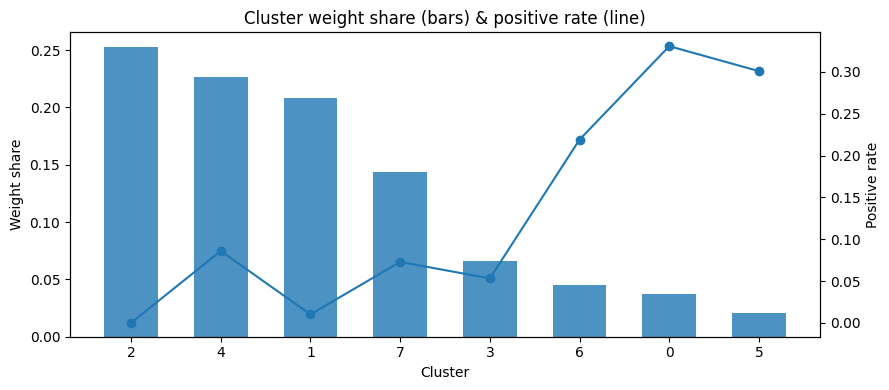

In [28]:
import matplotlib.pyplot as plt
import numpy as np

cs = cluster_summary.sort_values("weight_share", ascending=False).reset_index(drop=True)

fig, ax1 = plt.subplots(figsize=(9,4))
x = np.arange(len(cs))
bars = ax1.bar(x, cs["weight_share"].values, width=0.6, alpha=0.8)
ax1.set_ylabel("Weight share")
ax1.set_xticks(x)
ax1.set_xticklabels([int(c) for c in cs["cluster"]])
ax1.set_xlabel("Cluster")

ax2 = ax1.twinx()
ax2.plot(x, cs["pos_rate"].values, marker="o")
ax2.set_ylabel("Positive rate")

plt.title("Cluster weight share (bars) & positive rate (line)")
plt.tight_layout()
plt.show()


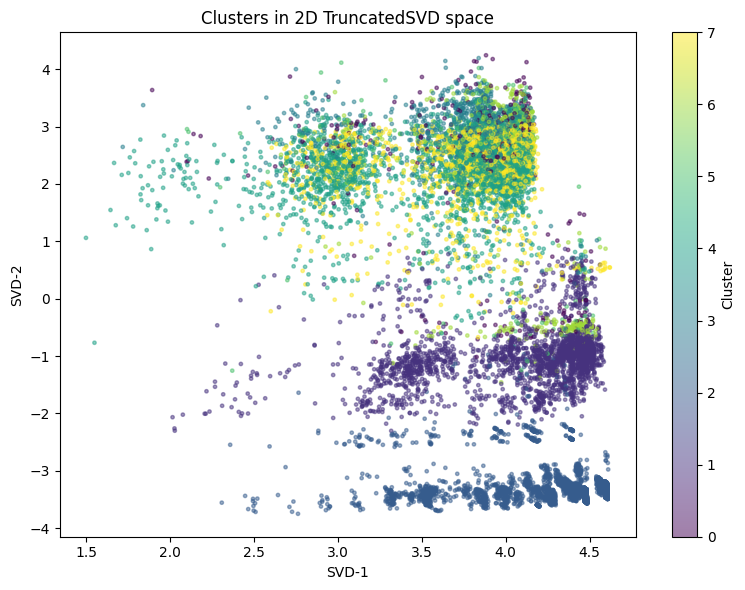

In [29]:
from sklearn.decomposition import TruncatedSVD
from scipy import sparse

# Ensure sparse
Xenc = X_train_enc
if not sparse.issparse(Xenc):
    from scipy import sparse as _sp
    Xenc = _sp.csr_matrix(Xenc)

# 2D projection
svd2 = TruncatedSVD(n_components=2, random_state=RANDOM_STATE)
Z = svd2.fit_transform(Xenc)

# Sample for plotting
nmax = 12000
idx = np.arange(Z.shape[0])
if Z.shape[0] > nmax:
    rng = np.random.default_rng(RANDOM_STATE)
    idx = rng.choice(Z.shape[0], size=nmax, replace=False)
Zs = Z[idx]
cls = np.array(train_clusters)[idx]

plt.figure(figsize=(8,6))
scatter = plt.scatter(Zs[:,0], Zs[:,1], c=cls, s=6, alpha=0.5)
plt.title("Clusters in 2D TruncatedSVD space")
plt.xlabel("SVD-1"); plt.ylabel("SVD-2")
cbar = plt.colorbar(scatter)
cbar.set_label("Cluster")
plt.tight_layout()
plt.show()


<Figure size 900x400 with 0 Axes>

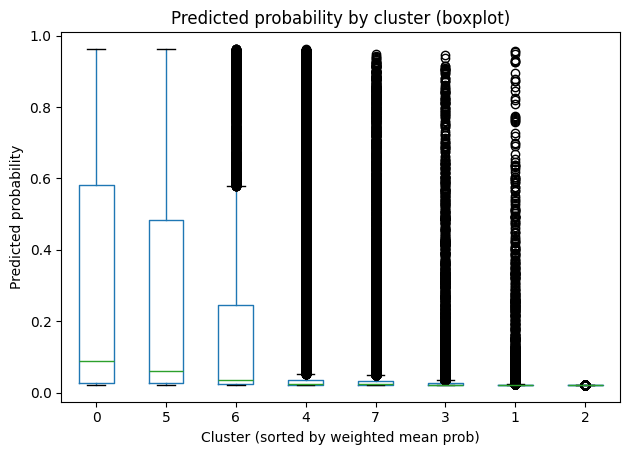

In [30]:
# Weighted mean probability per cluster (table)
df_prob = pd.DataFrame({
    "cluster": train_clusters,
    "prob":    best_pipe.predict_proba(X_train)[:,1],
    "y":       y_train,
    "w":       w_train
})
prob_agg = (df_prob
    .groupby("cluster")
    .apply(lambda g: pd.Series({
        "w_mean_prob": np.average(g["prob"], weights=g["w"]),
        "w_pos_rate":  np.average(g["y"],    weights=g["w"]),
        "n": len(g), "w_sum": g["w"].sum()
    }))
    .sort_values("w_mean_prob", ascending=False))
prob_agg

# Boxplot (unweighted visual), sorted by weighted mean prob
order = prob_agg.index.tolist()
plt.figure(figsize=(9,4))
df_prob_sorted = df_prob.copy()
df_prob_sorted["cluster"] = pd.Categorical(df_prob_sorted["cluster"], categories=order, ordered=True)
df_prob_sorted.boxplot(column="prob", by="cluster", grid=False)
plt.suptitle("")
plt.title("Predicted probability by cluster (boxplot)")
plt.xlabel("Cluster (sorted by weighted mean prob)")
plt.ylabel("Predicted probability")
plt.tight_layout()
plt.show()


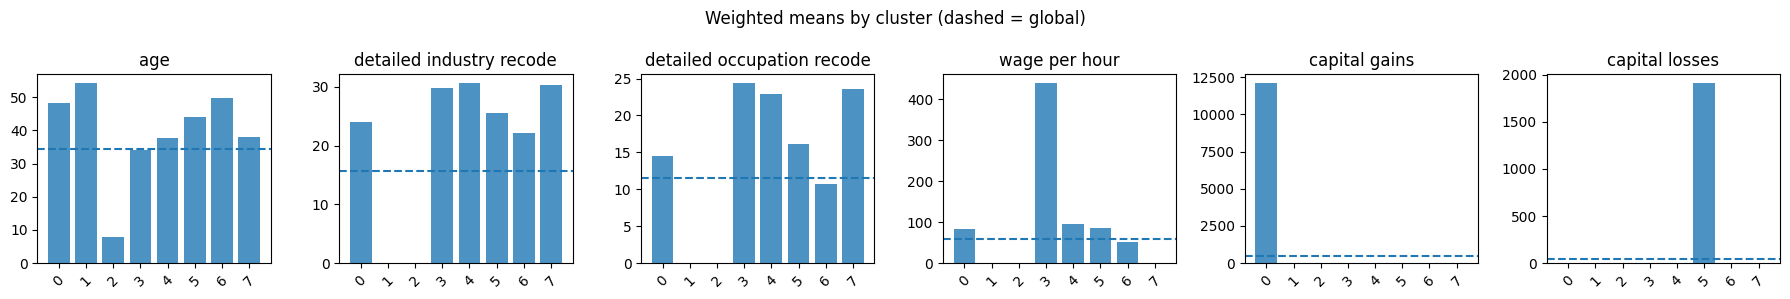

In [32]:
key_nums = num_cols[:6]  # pick a handful to avoid clutter
global_means = {c: np.average(X_train[c].fillna(X_train[c].median()), weights=w_train) for c in key_nums}

cl_means = []
for k in sorted(np.unique(train_clusters)):
    sub = X_train[train_clusters==k]
    wsub = w_train[train_clusters==k]
    row = {"cluster": int(k)}
    for c in key_nums:
        row[c] = float(np.average(sub[c].fillna(sub[c].median()), weights=wsub)) if len(sub)>0 else np.nan
    cl_means.append(row)
cl_means = pd.DataFrame(cl_means).set_index("cluster").sort_index()

# Plot
n = len(key_nums)
fig, axes = plt.subplots(1, n, figsize=(3*n, 3), sharey=False)
if n == 1: axes = [axes]
for i, c in enumerate(key_nums):
    ax = axes[i]
    ax.bar(cl_means.index.astype(str), cl_means[c].values, alpha=0.8)
    ax.axhline(global_means[c], linestyle="--")
    ax.set_title(c)
    ax.tick_params(axis='x', rotation=45)
plt.suptitle("Weighted means by cluster (dashed = global)")
plt.tight_layout()
plt.show()
